# Transform collected YouTube Files to Trainingsdata
We want to use two kinds of trainingdata. First we want to split every song in junks of circa 0.5 seconds and use them as trainingsdata to generate new junks. These junks get sorted in a 2 dimensional field by our autoencoder. The structure of a song can then be imagened as a movement trough the 2 dimensional field. We will store these "movements", i.e. a list of coordinates and use these lists as trainingsdata for another network. Finally we want to be able to generate new "movements", i.e. new sequences of waveset-junks on the one hand and the corresponding junks themselves on the other hand.

## Wavesets
Every track from the training data gets split in wavesets with a duration of aprox. 0.2 second.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import librosa
import librosa.display
import soundfile
from IPython.display import display, Audio
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE



In [2]:
np.random.seed(42)

### Loading data (demo track):

In [3]:
folder_path = 'demoData'
paths = librosa.util.find_files(folder_path, ext=['wav']) 
songs = []

for path in paths: 
    data, sr = librosa.load(path, sr = None, mono = True)
    songs.append(data)

### Waveset class

In [4]:
class Wavesets:
    def __init__(self, audio_data, sample_rate):
            self.data = audio_data
            self.sr = sample_rate
    
    def get_splitPoints(self, data):
        split_points = np.argwhere(
        (np.sign(data[:-1])==-1) & (np.sign(data[1:])==1)
        )
        return split_points
    
    def plot_wavesets(self, data, split_points, plot_range):
        data_range = data[plot_range[0]:plot_range[1]]
        plt.figure(figsize=(15, 5))
        plt.plot(data_range)
        plt.hlines(0.0, plot_range[0], plot_range[1], color='r')
        plt.vlines(split_points[(plot_range[0]<split_points) & (split_points<plot_range[1])], data_range.max(), data_range.min(), color='g')
        plt.xlabel("samples")
        plt.ylabel("amplitude")
        plt.title("Wavesets")
        plt.show();
        
    def resize_splits(self, splits, min_size):
        new_splits = []
        last_split = 0
        for split in splits:
            if (split - last_split) > min_size:
                last_split = split
                new_splits.append(split)
        return np.array(new_splits)
    

    def generate_wavesets(self, data, split_points):
        wavesets = []
        # we iterate over split points 2 times: once with no offset
        # and a 2nd time with an offset of 1 which gives us
        # the start and the end - zip allows us to iterate
        # over a collection of arrays in parallel
        for start, end in zip(split_points[:-1, 0], split_points[1:, 0]):
            wavesets.append(data[start:end+1])
            
        return wavesets
    
    def get_Wavesets(self, min_size):
        split_points = self.get_splitPoints(self.data)
        split_points = self.resize_splits(split_points, min_size)
        #self.plot_wavesets(data, split_points, plot_range=[0, self.sr * 60 * 7])
        wavesets = self.generate_wavesets(self.data, split_points)
        return wavesets

### Generate Wavesets
We can now generate all Wavesets. Later we want to be able to reconstruct the position of each waveset in the song. For this, we store how many wavesets each song is split into

In [5]:
all_wavesets = []
num_of_ws_per_song = []

for song in songs:
    wavesets = Wavesets(song, sr).get_Wavesets(sr/2) # The variable "wavesets" is a list of np-arrays (with the amplitudes stored in it).
    all_wavesets.extend(list(wavesets))  # all wavesets is a list of all wavesets
    num_of_ws_per_song.append(len(wavesets))

np.asarray(num_of_ws_per_song)

array([919, 641])

### Padding: Resize Wavesets
It's easier to work with arrays of the same size. The wavesets do not have the exact same size at the moment, because the zero-crossing is a contigent feature. We will fill the shorter waveset-arrays with zeros.

In [6]:
def find_max_list(list):
    list_len = [len(i) for i in list]
    max_len = max(list_len)
    return max_len

max_len_ws = find_max_list(all_wavesets)

for index, ws in enumerate(all_wavesets):
    missing_items = max_len_ws - len(ws)
    all_wavesets[index] = np.pad(all_wavesets[index], (0, missing_items), 'constant', constant_values=(0,0))

### Spectograms of Wavesets
We're going to create spectograms of each Waveset. We can use a mel-spectogram or a normal spectogram. 

In [7]:
def extract_log_spectogram(pcm_data, n_fft, hop_length, win_length):
    stft = librosa.stft(pcm_data, n_fft=n_fft, hop_length=hop_length, win_length=win_length)[:-1]
    spectogram = np.abs(stft)
    log_spectogram = librosa.amplitude_to_db(spectogram)
    return log_spectogram

In [8]:
def extract_mel_spectogram(pcm_data, bins, hops, winl):
        spectogram = librosa.feature.melspectrogram(y=pcm_data, sr=sr, hop_length=hops, win_length=winl, n_fft=bins)
        spectogram = librosa.amplitude_to_db(spectogram)
        return spectogram 

In [9]:
WIN_LENGTH = int(sr/30)
HOP_LENGTH = int(sr/40)
N_FFT = int(sr/20)

all_wavesets_specto = []

for ws in all_wavesets:
    waveset_specto = extract_mel_spectogram(ws, N_FFT, HOP_LENGTH, WIN_LENGTH)
    all_wavesets_specto.append(waveset_specto)


We can look at the spectogram of a random waveset to see that everything works.

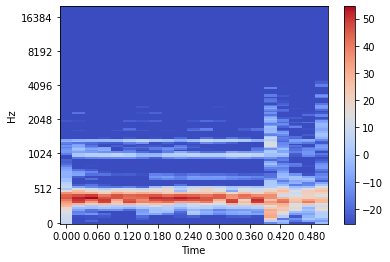

In [10]:
librosa.display.specshow(
    all_wavesets_specto[np.random.randint(0,len(all_wavesets_specto))],
    x_axis='time',
    y_axis='mel',
    sr=sr,
    fmax=20000,
    hop_length=HOP_LENGTH,
)
plt.colorbar()
plt.show()

We do not normalize our samples, because we want to preserve the loudness of each waveset

### Save spectograms
We save the data on disk for later use.

In [11]:
save_path = "data\spectos.npy"
np.save(save_path,all_wavesets_specto)

save_path2 = "data\wsPerSong.npy"
np.save(save_path2, num_of_ws_per_song)


The data can be loaded like this:

In [12]:
loaded_data1 = np.load("data\spectos.npy")
print(loaded_data1)
loaded_data2 = np.load("data\wsPerSong.npy")
print(loaded_data2)

[[[ -20.815638   -58.817146   -77.60848   ...  -82.070274   -79.266884
    -74.496185 ]
  [ -15.551481   -60.648617   -64.40522   ...  -72.42103    -76.83318
    -64.954185 ]
  [ -10.922694   -18.842852   -19.355743  ...  -48.44336    -52.808846
    -50.97656  ]
  ...
  [ -82.070274   -82.070274   -82.070274  ...  -82.070274   -82.070274
    -82.070274 ]
  [ -82.070274   -82.070274   -82.070274  ...  -82.070274   -82.070274
    -82.070274 ]
  [ -82.070274   -82.070274   -82.070274  ...  -82.070274   -82.070274
    -82.070274 ]]

 [[ -72.38767    -72.38767    -72.38767   ...  -72.38767    -72.38767
    -72.38767  ]
  [ -72.38767    -69.85343    -72.38767   ...  -68.34876    -63.551678
    -72.38767  ]
  [ -70.735374   -54.572697   -58.67726   ...  -68.529976   -68.98572
    -65.07602  ]
  ...
  [ -72.38767    -72.38767    -72.38767   ...  -72.38767    -72.38767
    -72.38767  ]
  [ -72.38767    -72.38767    -72.38767   ...  -72.38767    -72.38767
    -72.38767  ]
  [ -72.38767    -72.38